In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import QuantileTransformer

# READ DF + NORMALIZE

In [2]:
df = pd.read_csv("sonar.csv")
df = df.loc[:, ~df.columns.isin(['Class'])]
df.dropna(inplace=True)

quantile_trans = QuantileTransformer(n_quantiles=208, output_distribution='normal')
df_scaled = pd.DataFrame(quantile_trans.fit_transform(df), columns=df.columns)
df_scaled

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,...,attribute_51,attribute_52,attribute_53,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60
0,-0.301170,0.250847,0.301170,-0.996843,0.582268,0.103112,0.670694,0.511936,1.273337,0.225930,...,0.866031,-2.019086,-0.410882,0.866031,-0.072720,1.493655,1.493655,0.320232,0.525790,-0.611207
1,1.058440,0.772846,1.329828,0.716909,0.938814,1.974639,1.457684,1.827445,1.423507,0.814325,...,-0.207334,-0.444052,-0.066651,-0.797569,0.307511,1.711675,1.195520,-0.282216,-0.313866,-0.232145
2,0.213525,0.892769,1.531670,1.273337,0.625869,1.711675,1.827445,1.974639,2.067922,2.339227,...,-1.359737,1.195520,0.883786,0.030278,1.220640,2.067922,2.587703,1.390915,0.589456,0.560880
3,-1.101840,-0.640667,0.822789,-1.037470,-1.390915,-1.329828,0.018165,0.213525,-1.287076,-0.498180,...,0.901825,0.133599,-1.101840,0.740598,0.201152,0.084867,-0.294840,-0.437380,-0.633251,1.220640
4,1.711675,1.124338,0.444052,-0.097027,-0.127492,-0.716909,0.188810,1.359737,1.572037,1.615141,...,0.225930,-1.661474,-0.633251,0.194977,0.511936,-1.766603,0.182650,-0.326612,0.732656,0.831313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,-0.417478,0.164211,-0.814325,-1.147421,-0.625869,1.058440,1.220640,0.670694,0.670694,0.670694,...,0.596675,0.018165,0.042395,1.171132,-1.058440,0.611207,0.060584,0.822789,1.493655,1.711675
204,0.525790,-1.195520,-0.158077,0.417478,0.326612,0.054519,-0.238370,-0.225930,-0.596675,0.288522,...,-1.079885,-0.901825,-0.036336,0.525790,-0.232145,-0.127492,-0.781034,-0.822789,-0.018165,0.320232
205,1.220640,0.505046,-0.716909,-0.470943,-0.764710,0.391196,0.225930,0.103112,-0.275921,0.539746,...,0.194977,0.567980,-1.315310,-0.756624,-0.275921,0.333005,1.195520,1.037470,0.294840,-0.663131
206,0.417478,0.188810,0.484517,0.567980,-1.661474,0.701339,0.582268,0.006055,0.457456,0.464189,...,-1.246556,-0.417478,-0.781034,0.444052,-0.929448,-0.929448,-0.781034,0.257100,-0.701339,-0.170351


# Robust Trimmed K Means


In [3]:
import sys
sys.path.append("../RTKM")
from RTKM import * 
from AccuracyMeasures import *
from ClusteringMethods import *

#generate data RTKM untuk comply dengan func silhouette score
def generate_data_RTKM(dataframe, k, percent_outliers, num_members):
    dataframe_np_transposed = dataframe.to_numpy().T

    RTKM_data = RTKM(dataframe_np_transposed)
    RTKM_data.perform_clustering(k=k, percent_outliers = percent_outliers, max_iter = 100, num_members = num_members)
    print(k, percent_outliers, num_members)
    
    #pred clusters return cluster id for data index, pred outliers return outlier index
    pred_clusters, pred_outliers = RTKM_data.return_clusters()

    #Append dataset sehingga mendapatkan id
    cluster_id_RTKM = pd.DataFrame(pred_clusters, columns=['cluster_id'])
    RTKM_result = pd.merge(df_scaled, cluster_id_RTKM, left_index=True, right_index=True)

    # Create a mask for the indices in the DataFrame that need to be modified
    mask = np.isin(RTKM_result.index, pred_outliers)

    # Use np.where to conditionally replace values in cluster_id
    RTKM_result['cluster_id'] = np.where(mask, RTKM_result['cluster_id'].astype(str) + '-out', RTKM_result['cluster_id'])
    all_data = RTKM_result

    # Use boolean indexing to filter out rows based on indices_to_remove
    filtered_data = RTKM_result[~RTKM_result.index.isin(pred_outliers)]
    
    return filtered_data, all_data

# TEST RTKM ALGORITHM with K = 3 and n_percentage = 10

3 0.1 2


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)


<Figure size 800x800 with 0 Axes>

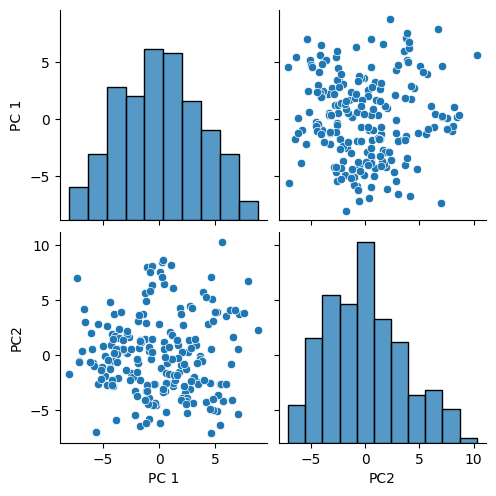

<Figure size 800x800 with 0 Axes>

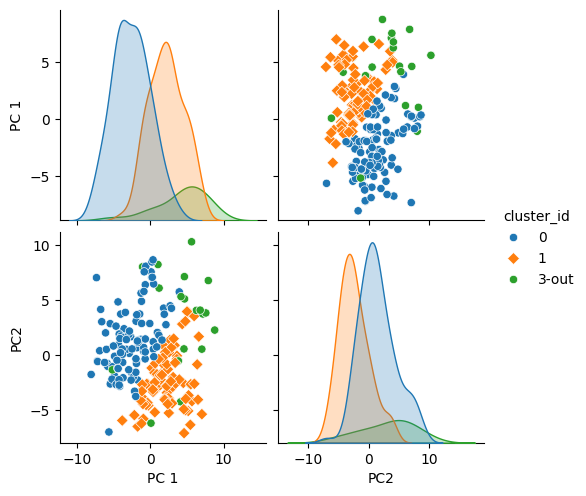

<Figure size 800x800 with 0 Axes>

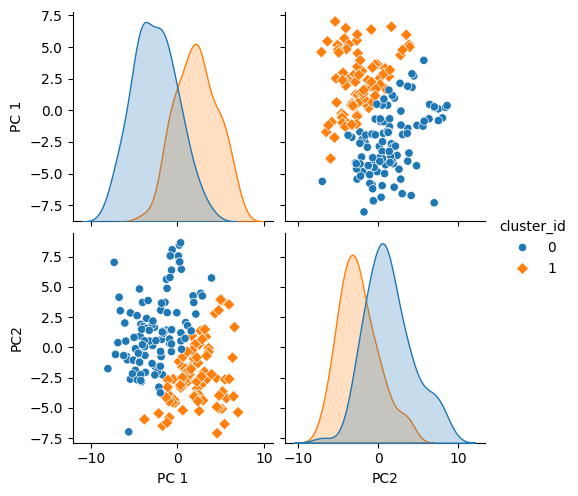

In [4]:
# TEST VISUALIZATION
from sklearn.decomposition import PCA
import seaborn as sns 
from sklearn.metrics import silhouette_score

# PCA variable input
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca, columns=['PC 1', 'PC2'])
plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca)

# GET inliers (RTKM_result_filtered) and optimal cluster (RTKM_result)
RTKM_result_filtered, RTKM_result = generate_data_RTKM(df_scaled, 3, 0.10, 2)

#PAIR PLOT with OUTLIERS
df_pca['cluster_id'] = RTKM_result.loc[:, RTKM_result.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"])

#PAIR PLOT without OUTLIERS
df_pca['cluster_id'] = RTKM_result_filtered.loc[:, RTKM_result_filtered.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"])

In [5]:
#FIND SILHOUETTE SCORE
score = silhouette_score(RTKM_result_filtered.drop(['cluster_id'], axis=1), RTKM_result_filtered['cluster_id'])

print(score)

0.1178422632302569


## OPTIMAL PERCENTAGE

In [6]:
from sklearn.metrics import silhouette_score

# Function find optimal RTKM cluster
def find_optimal_RTKM(df, n_cluster):
    best_score = -1
    best_percent = 0
    best_cluster = None
    best_all = None

    for percent in range(5, 35, 5):
        print("PERCENT:", percent)

        # Jalankan RTKM dengan parameter tertentu
        retry_count = 0
        max_retries = 5  # Tentukan jumlah maksimum percobaan

        while retry_count < max_retries:
            inliers, all_data = generate_data_RTKM(df, n_cluster, percent / 100, 2)
            inliers_no_id = inliers.drop(['cluster_id'], axis=1)

            print(inliers.shape)

            # Skip invalid data
            if inliers["cluster_id"].nunique() == 1:
                print("Invalid data, retrying...")
                retry_count += 1
                continue

            # Hitung skor siluet
            score = silhouette_score(inliers_no_id, inliers['cluster_id'])
            print("Score:", score)

            if inliers["cluster_id"].nunique() != n_cluster:
                print("NOTE THAT THE CENTROID DOES NOT MATCH K VALUE")

            # Perbarui parameter terbaik jika skor lebih tinggi
            if score > best_score:
                best_score = score
                best_percent = percent
                best_cluster = inliers
                best_all = all_data

            break  # Keluar dari loop retry jika data valid
    
    print("====================================================")
    print("Best Silhouette Score:", best_score)
    print("Best Percent:", best_percent)

    return best_cluster, best_all

optimal_inlier, optimal_cluster = find_optimal_RTKM(df_scaled, 3)

PERCENT: 5
3 0.05 2
(198, 61)
Score: 0.08955275579201556
NOTE THAT THE CENTROID DOES NOT MATCH K VALUE
PERCENT: 10
3 0.1 2
(188, 61)
Score: 0.1175654015481152
NOTE THAT THE CENTROID DOES NOT MATCH K VALUE
PERCENT: 15
3 0.15 2
(177, 61)
Invalid data, retrying...
3 0.15 2
(177, 61)
Invalid data, retrying...
3 0.15 2
(177, 61)
Score: 0.12232003436612655
NOTE THAT THE CENTROID DOES NOT MATCH K VALUE
PERCENT: 20
3 0.2 2
(167, 61)
Invalid data, retrying...
3 0.2 2
(167, 61)
Score: 0.10771895786227574
NOTE THAT THE CENTROID DOES NOT MATCH K VALUE
PERCENT: 25
3 0.25 2
(156, 61)
Score: 0.1175024533650182
NOTE THAT THE CENTROID DOES NOT MATCH K VALUE
PERCENT: 30
3 0.3 2
(146, 61)
Score: 0.09176741568980235
NOTE THAT THE CENTROID DOES NOT MATCH K VALUE
Best Silhouette Score: 0.12232003436612655
Best Percent: 15


In [8]:
# Davies Bouldin Score INLIERS SAJA
from sklearn.metrics import davies_bouldin_score
score = davies_bouldin_score(optimal_inlier.drop('cluster_id', axis=1), optimal_inlier['cluster_id'])
print(score)

2.4719696013358368


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)


<Figure size 800x800 with 0 Axes>

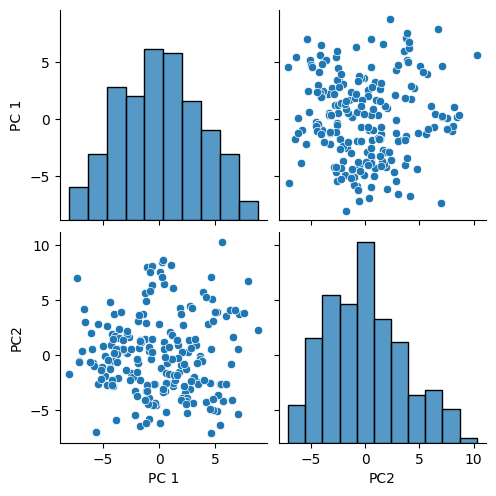

<Figure size 800x800 with 0 Axes>

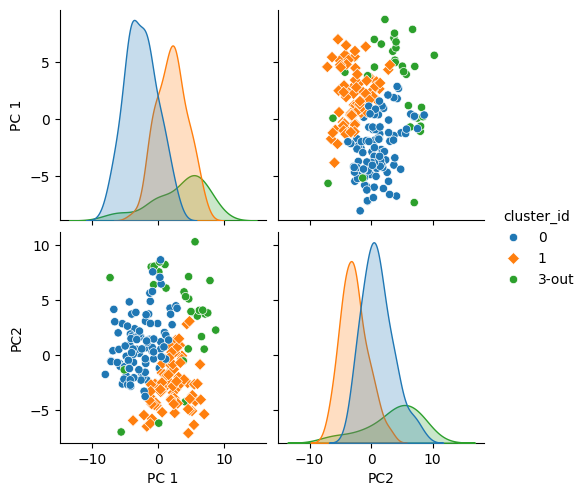

<Figure size 800x800 with 0 Axes>

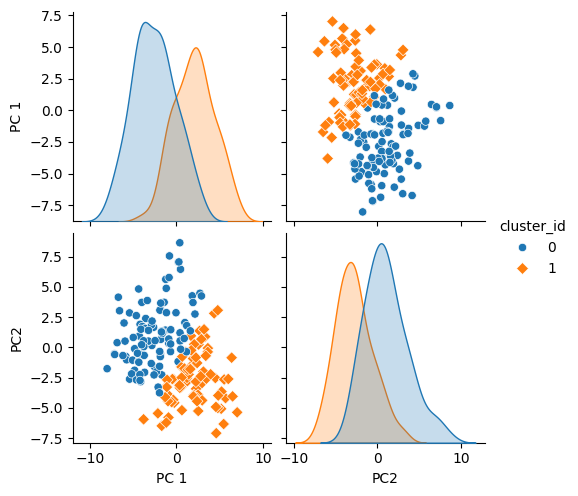

In [7]:
# OPTIMAL VISUALIZATION
from sklearn.decomposition import PCA
import seaborn as sns 

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca, columns=['PC 1', 'PC2'])
plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca)

#PAIR PLOT OPTIMAL with OUTLIERS
df_pca['cluster_id'] = optimal_cluster.loc[:, optimal_cluster.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"])

#PAIR PLOT OPTIMAL without OUTLIERS
df_pca['cluster_id'] = optimal_inlier.loc[:, optimal_inlier.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"])